# Estudio de métodos de control con aproximaciones

Este estudio pertenece a la parte 2 de la práctica 1 correspondiente a la asignatura Extensiones de Machine Learning del máster de IA en la Universidad de Murcia.

El grupo de alumnos que han realizado el estudio está conformado por:

- Tomás Díaz Díaz
- Jose Antonio Sánchez Fernández

## Introducción

Este notebook explora técnicas de aprendizaje por refuerzo que requieren aproximación de funciones:
- SARSA semi-gradiente
- Deep Q-Learning (DQN)

Para la realización del estudio, se utilizará el entorno ***Gymnasium***. Ambas técnicas serán evaluadas en el escenario `CartPole-v1`, consistente en un carro que debe mantener una barra en equilibrio mediante el movimento a izquierda. El espacio de estados en este escenario es continuo y el espacio de acciones es discreto, como veremos durante la creación del entorno. Cada episodio del experimento termina cuando la barra cae o transcurren 500 pasos.

## Imports y configuración

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from collections import deque
from tqdm import tqdm
import random
import gc

import torch
import torch.nn as nn
import torch.optim as optim

import sys
sys.path.append('src/')
from AgentSARSASemiGradiente import AgentSARSASemiGradiente
from AgentDeepQLearning import AgentDQLearning
import utils

## Preparación del entorno

In [2]:
# Declaramos una semilla para la reproducibilidad de los resultados y modificación del entorno CartPole
SEMILLA = 42
np.random.seed(SEMILLA) 
np.random.default_rng(SEMILLA)
torch.manual_seed(SEMILLA)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

gc.collect()
torch.cuda.empty_cache()

# Inicializamos el entorno de CartPole
env_name = "CartPole-v1"
sarsa_sg_env = utils.make_env(env_name, seed=SEMILLA)
dql_env = utils.make_env(env_name, seed=SEMILLA)

# TODO Posible sustitución por un Wrapper para observar mejor las dimensiones del entorno
n_episodes = 1000
sarsa_sg_env = gym.wrappers.RecordEpisodeStatistics(sarsa_sg_env, buffer_length=n_episodes)
dql_env = gym.wrappers.RecordEpisodeStatistics(dql_env, buffer_length=n_episodes)

# Usamos el entorno SARSA-SG como ejemplo para obtener las dimensiones del espacio de estados y acciones
state_dim = sarsa_sg_env.observation_space.shape[0]
action_dim = sarsa_sg_env.action_space.n
print(f"Estado: {state_dim} dimensiones, Acciones: {action_dim}")
print(f"Dimensiones: {sarsa_sg_env.observation_space}")

Usando dispositivo: cpu
Estado: 4 dimensiones, Acciones: 2
Dimensiones: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)


**¿Qué estamos viendo en este entorno?**

Lo que nos dice esta salida de las características del entorno es que disponemos de 4 dimensiones basadas en las variables que influyen en la localización espacial del carrito, y 2 acciones que podemos realizar con él.
Sobre las dimensiones, por la documentación del escenario concreto, sabemos que consisten en las siguientes:

| Dimensión                    |  Límites mostrados              | Tipo de dato |
|------------------------------|---------------------------------|--------------|
| Posición del carrito (x)     | [-4.8, 4.8]                     | `float32`    |
| Velocidad del carrito (v)    | [-inf, inf]                     | `float32`    |
| Ángulo del poste en radianes | [-0.41887903, 0.41887903]       | `float32`    |
| Velocidad angular del poste  | [-inf, inf]                     | `float32`    |

Estas dimensiones son las que influyen en la cantidad de estados de los que dispondrán nuestros agentes para moverse y alcanzar una política. Sin embargo, al haber variables sin un rango discreto, vemos que habrá una cantidad infinita de estados, por lo que los métodos tabulares dejan de ser viables en un escenario como este. Es por ello que utilizaremos este entorno para demostrar la funcionalidad de los métodos de control por aproximaciones.

**¿Cuál es el objetivo del entorno?**

En este escenario, el objetivo es que el agente mantenga estable el poste encima del carrito durante 500 pasos, teniendo que tomar decisiones en cada paso dados los estados en los que se encuentran el carrito y el poste. Por ello, puede haber tres situaciones que den por finalizado el escenario: 

- **Se falla el objetivo** si se alcanzan los siguientes valores en las dimensiones:
    - El ángulo del poste es mayor que ±12° (0,20944 radianes)
    - La posición del carrito es mayor que ±2.4, saliéndose de los límites de la imagen proyectada
- **Se cumple el objetivo** al alcanzar los 500 pasos con el poste sobre el carrito manteniendo las dos variables previamente mencionadas dentro de sus límites.

Inicialmente, las cuatro variables que conforman las dimensiones del escenario obtienen un valor aleatorio uniforme entre -0.05 y 0.05 (aunque esto puede ser modificado a nuestro antojo en la creación). Tras esto, el agente tomará una acción posible para mantener el poste estable dentro de los límites, ya sea empujando el carrito hacia la izquierda o hacia la derecha.

## Creación de agentes

In [4]:
sarsa_agent = AgentSARSASemiGradiente(state_dim, action_dim, alpha=0.01, gamma=0.99, epsilon=0.1)

dql_agent = AgentDQLearning(state_dim, action_dim, gamma=0.99, epsilon=0.1, lr=0.01)

En la creación de los agentes buscamos mantener una uniformidad para sus parámetros de forma que aseguremos que las condiciones sean justas e iguales para ambos, ya que queremos que afronten el mismo problema bajo la misma configuración. Para ello, se igualan el factor de descuento en las recompensas (*gamma*), el nivel de exploración del agente (*epsilon*) y su tasa de aprendizaje (*alpha*/*learning_rate*).

## Entrenamiento

In [5]:
sarsa_rewards, sarsa_steps, sarsa_actions, sarsa_pole_angles, sarsa_cart_positions = sarsa_agent.train(sarsa_sg_env, n_episodes=n_episodes)
dql_rewards, dql_steps, dql_actions, dql_pole_angles, dql_cart_positions = dql_agent.train(dql_env, n_episodes=n_episodes)

# Guardamos estadísticas para las gráficas
training_stats = {
    "SARSA Semi-Gradiente": {
        "rewards": sarsa_rewards,
        "steps": sarsa_steps,
        "actions": sarsa_actions,
        "pole_angles": sarsa_pole_angles,
        "cart_positions": sarsa_cart_positions
    },
    "Deep Q-Learning": {
        "rewards": dql_rewards,
        "steps": dql_steps,
        "actions": dql_actions,
        "pole_angles": dql_pole_angles,
        "cart_positions": dql_cart_positions
    }
}

Lo primero que debemos abordar es la cuestión de qué estadísticas hemos escogido como métricas del entrenamiento y rendimiento de ambos agentes, y posteriormente analizaremos los resultados de cada uno utilizando dichas métricas. Las medidas escogidas para este estudio han sido las siguientes:

- **Recompensa alcanzada por episodio** (acompañada de los **pasos de duración del episodio**, aunque entraremos en detalle en su apartado).
- **Acciones tomadas** por el agente.
- **Ángulos del poste** por cada episodio.
- **Posiciones del carrito** por episodio.

In [6]:
print("Primeros 5 elementos de sarsa_rewards:", sarsa_rewards[:5])
print("Primeros 5 elementos de sarsa_lengths:", sarsa_steps[:5])

Primeros 5 elementos de sarsa_rewards: [9.0, 9.0, 9.0, 9.0, 8.0]
Primeros 5 elementos de sarsa_lengths: [9, 9, 9, 9, 8]


In [30]:
print(sarsa_pole_angles)

{0: [np.float32(0.02611397), np.float32(0.026686098), np.float32(0.033274356), np.float32(0.045882165), np.float32(0.064549446), np.float32(0.089351535), np.float32(0.12039734), np.float32(0.15782654), np.float32(0.19019549)], 1: [np.float32(-0.012920198), np.float32(-0.012066668), np.float32(-0.01714776), np.float32(-0.028158143), np.float32(-0.045129247), np.float32(-0.0681284), np.float32(-0.09725728), np.float32(-0.13264948), np.float32(-0.17446712)], 2: [np.float32(-0.00565858), np.float32(-0.0062041027), np.float32(-0.012638883), np.float32(-0.024966324), np.float32(-0.043226495), np.float32(-0.067495145), np.float32(-0.09788198), np.float32(-0.1345281), np.float32(-0.17760248)], 3: [np.float32(0.032763116), np.float32(0.033026446), np.float32(0.039346524), np.float32(0.05172485), np.float32(0.0701994), np.float32(0.09484354), np.float32(0.12576415), np.float32(0.15145184), np.float32(0.1837249)], 4: [np.float32(0.047069803), np.float32(0.047856044), np.float32(0.05478538), np.fl

## Evaluación

In [31]:
def plot_rewards(rewards, title, rolling_window=100):
    plt.figure(figsize=(16, 6))
    # moving_avg = utils.get_moving_avgs(rewards, rolling_window, 'valid')
    # plt.plot(moving_avg, label="Recompensa media móvil")
    plt.plot(rewards, label="Recompensa total por episodio")
    plt.title(title)
    plt.xlabel("Episodio")
    plt.ylabel("Recompensa obtenida")
    plt.grid(True)
    plt.legend()
    plt.show()


# def plot_steps(training_stats, rolling_window=100):
#     plt.figure(figsize=(12, 6))
#     for name, stats in training_stats.items():
#         moving_avg = utils.get_moving_avgs(stats["lengths"], rolling_window, 'valid')
#         plt.plot(moving_avg, label=name)
#     plt.title(f"Duración media móvil del episodio (ventana = {rolling_window})")
#     plt.xlabel("Episodio")
#     plt.ylabel("Longitud del episodio")
#     plt.grid(True)
#     plt.legend()
#     plt.show()


def plot_action_distribution_from_counts(action_counts, title="Distribución de acciones"):
    actions = list(action_counts.keys())
    counts = [action_counts[a] for a in actions]

    plt.figure(figsize=(6, 4))
    plt.bar(actions, counts, tick_label=[str(a) for a in actions])
    plt.xlabel("Acción")
    plt.ylabel("Frecuencia")
    plt.title(title)
    plt.show()


# def plot_variable_summary_by_agent(training_stats, key, title):
#     plt.figure(figsize=(10, 5))
#     for agent, stats in training_stats.items():
#         all_values = []
#         for episode_values in stats[key].values():
#             all_values.extend(episode_values)

#         mean_val = np.mean(all_values)
#         max_val = np.max(all_values)
#         std_val = np.std(all_values)

#         plt.bar(agent, mean_val, yerr=std_val, capsize=8, label=f"Max: {max_val:.2f}")

#     plt.title(f"Promedio ± desviación estándar de {title}")
#     plt.ylabel(title)
#     plt.grid(True)
#     plt.legend()
#     plt.show()
def plot_variable_summary(variable_dict, title):
    all_values = []
    for episode_values in variable_dict.values():
        all_values.extend(episode_values)

    mean_val = np.mean(all_values)
    max_val = np.max(all_values)
    min_val = np.min(all_values)
    std_val = np.std(all_values)

    plt.figure(figsize=(8, 5))
    plt.bar(["Media", "Máximo", "Mínimo"], [mean_val, max_val, min_val], yerr=[std_val, 0, 0], capsize=8)
    plt.title(title)
    plt.ylabel("Valor")
    plt.grid(True)
    plt.show()


def plot_variable_over_episode(stats_dict, episode_idx, variable_name, title=""):
    plt.figure(figsize=(10, 4))
    for agent_name, stats in stats_dict.items():
        values = stats[variable_name].get(episode_idx, [])
        plt.plot(values, label=agent_name)

    plt.title(f"{title} en el Episodio {episode_idx}")
    plt.xlabel("Paso del episodio")
    plt.ylabel(title)
    plt.grid(True)
    plt.legend()
    plt.show()


### SARSA Semi-gradiente

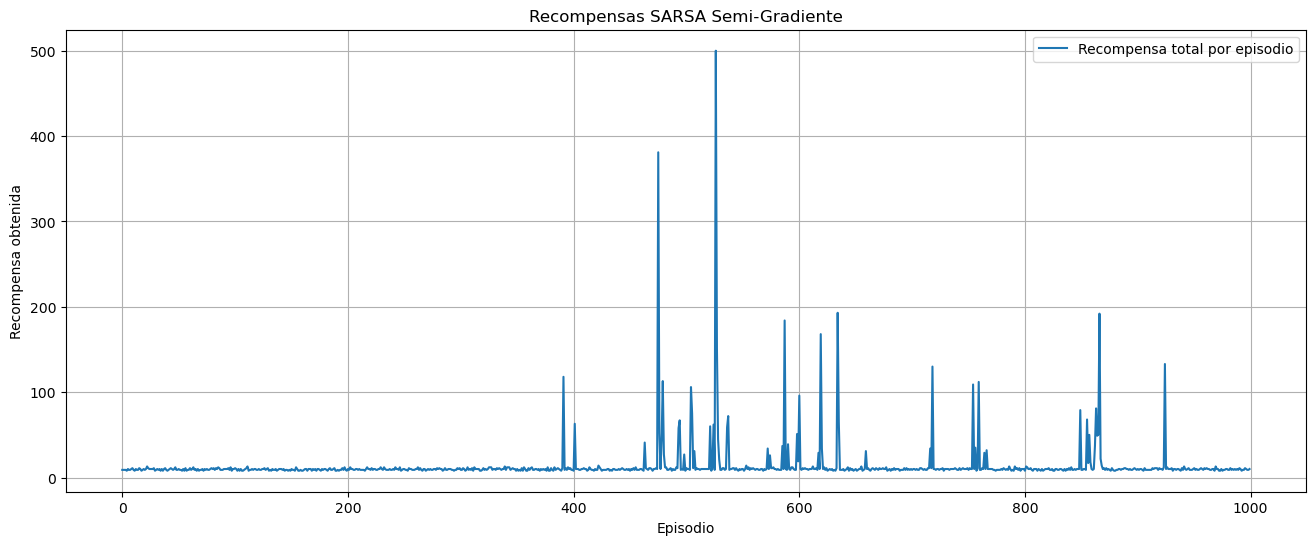

500.0 8.0 13.619 25.613118494240407


In [21]:
plot_rewards(sarsa_rewards, title="Recompensas SARSA Semi-Gradiente", rolling_window=100)
print(max(sarsa_rewards), min(sarsa_rewards), np.mean(sarsa_rewards), np.std(sarsa_rewards))

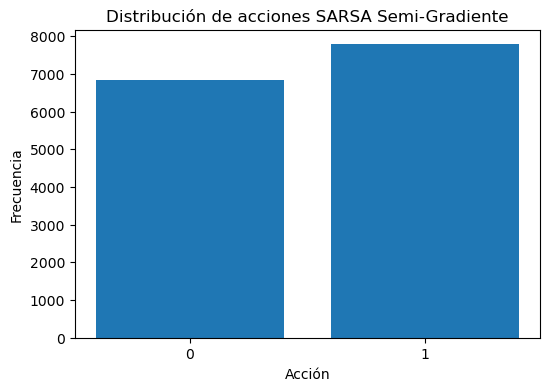

In [27]:
plot_action_distribution_from_counts(sarsa_actions, title="Distribución de acciones SARSA Semi-Gradiente")

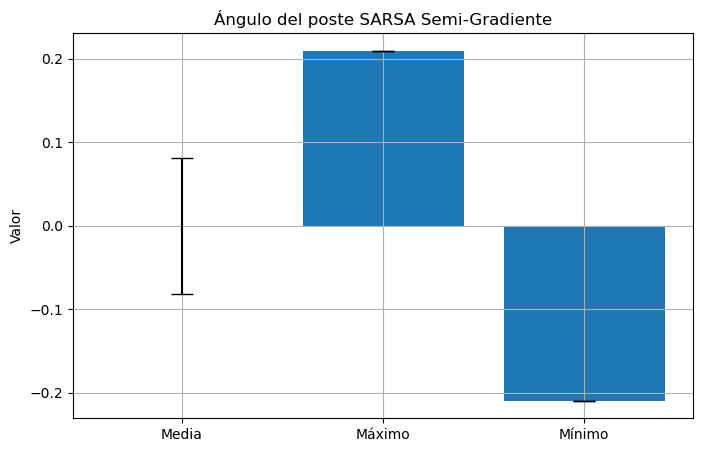

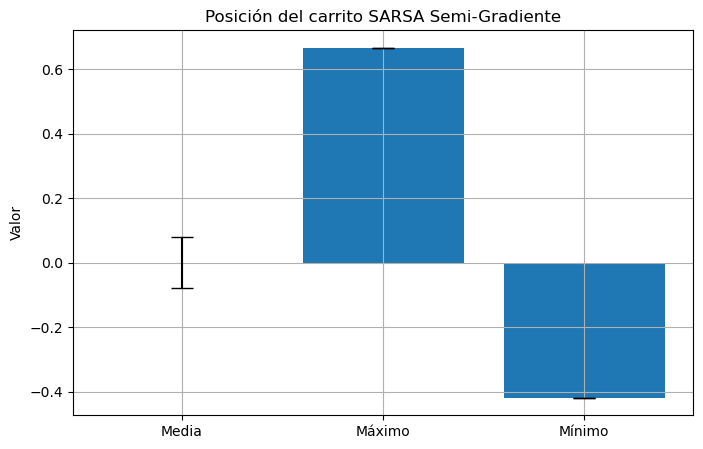

In [34]:
plot_variable_summary(sarsa_pole_angles, title="Ángulo del poste SARSA Semi-Gradiente")
plot_variable_summary(sarsa_cart_positions, title="Posición del carrito SARSA Semi-Gradiente")

### Deep-Q Learning

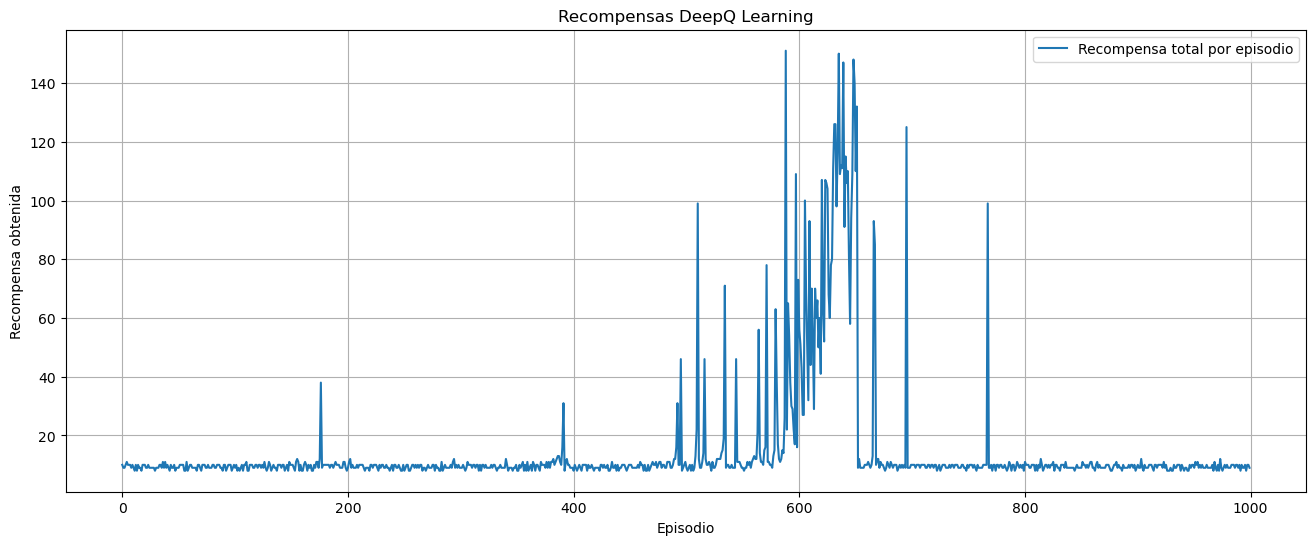

151.0 8.0 14.962 20.739058705736863


In [38]:
plot_rewards(dql_rewards, title="Recompensas DeepQ Learning", rolling_window=100)
print(max(dql_rewards), min(dql_rewards), np.mean(dql_rewards), np.std(dql_rewards))

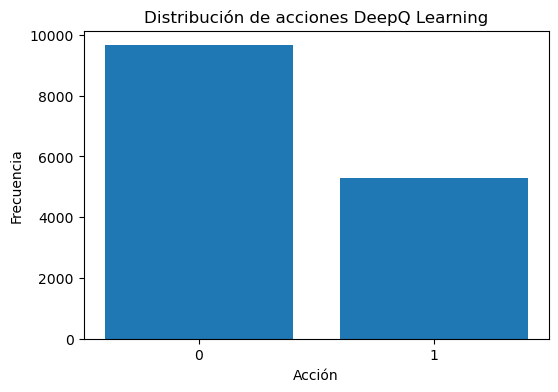

In [40]:
plot_action_distribution_from_counts(dql_actions, title="Distribución de acciones DeepQ Learning")

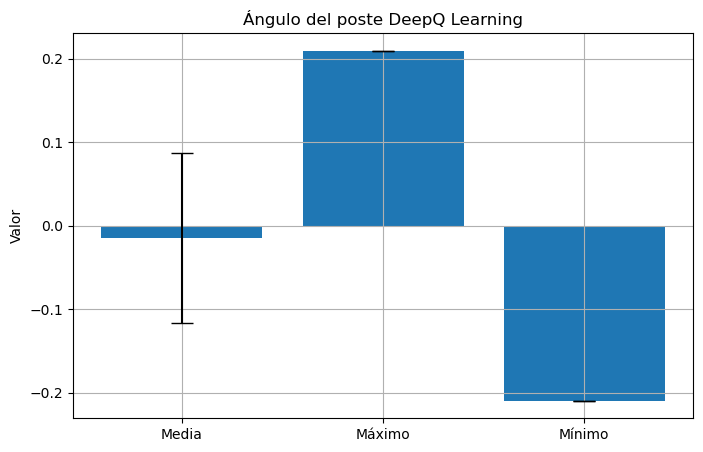

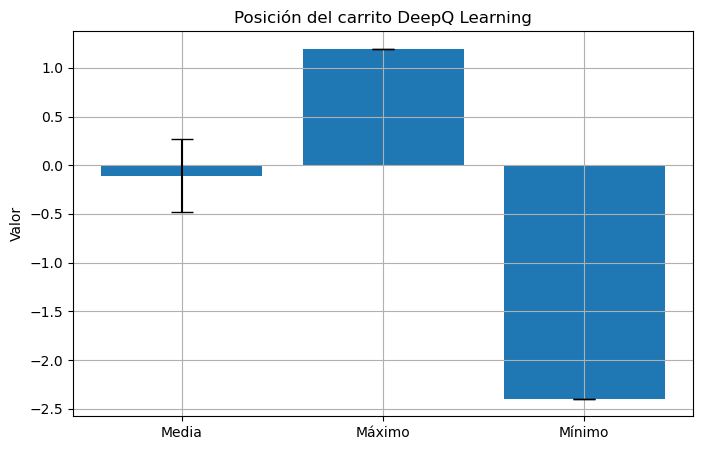

In [41]:
plot_variable_summary(dql_pole_angles, title="Ángulo del poste DeepQ Learning")
plot_variable_summary(dql_cart_positions, title="Posición del carrito DeepQ Learning")

## Análisis de resultados

In [ ]:
# TODO Mostrar diferencias en rendimiento y comportamiento

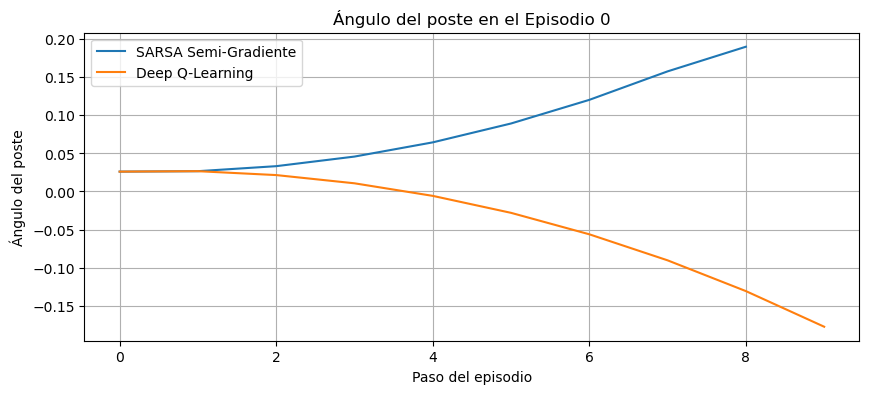

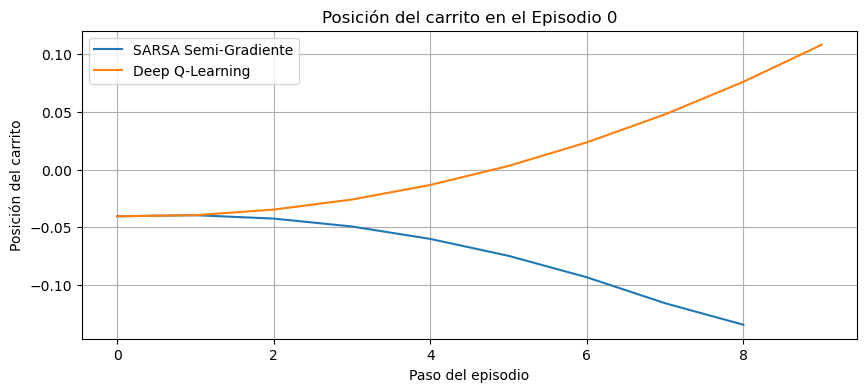

In [43]:
plot_variable_over_episode(training_stats, episode_idx=0, variable_name="pole_angles", title="Ángulo del poste")
plot_variable_over_episode(training_stats, episode_idx=0, variable_name="cart_positions", title="Posición del carrito")